In [4]:
import csv
import math
import pickle
import gzip
import random
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pylab as plt

In [5]:
# read in data as pandas dataframe
df = pd.read_csv('data/data_sanitized.csv')

# drop a couple of different metrics
del df['County']
del df['Total Sum Cases']
del df['Number of MIP Charges']

# generate validation and training ids
# ids are indices in df
N = len(df)
valid_ids = np.asarray(random.sample(range(N), int(N/5)))
train_ids = np.asarray([i for i in range(N) if i not in valid_ids])

# seperating labels from features
X = np.asarray(df[['Days Since March 17', 
                 'Population', 
                 'Average Cases Per 7 Days', 
                 'Average Daily Change in Cases Per 7 Days', 
                 'Area of County']].copy())
y = np.asarray(df[['New Cases per Day']].copy())

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, explained_variance_score, precision_score

# using train_test_split() to create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [7]:
# measure of predictions that lie within a margin of the actual
def check_accuracy(y_predict, y_true, variance=.1):
    correct = 0

    for i, j in enumerate(y_predict):
        if abs(j-y_true[i]) <= (variance * y_true[i]): 
            correct += 1
        
    return correct / len(y_predict)


# measure of predictions that lie outside of a margin of the actual
def check_inaccuracy(y_predict, y_true, variance=.5):
    incorrect = 0

    for i, j in enumerate(y_predict):
        # print(abs(j-y_true[i]),(variance * y_true[i]))
        if abs(j-y_true[i]) > (variance * y_true[i]): 
            incorrect += 1
        
    return incorrect / len(y_predict)

**Finding Best Parameters for Random Forest**

Below we set up a random forest that iterates through a set of possible estimators, criterion functions and implementing bootstrapping. This provides us with an optimized set of parameters for estimating the number of COVID19 cases on a given day.

Accuracy has been defined as an estimate within $\pm 25\%$ of the actual value. Innacuracy has been defined as outside of $\pm 75\%$ of the actual value.

In [8]:
# define parameters to test
estimators = [50, 100, 150]
criteria = ['gini', 'entropy']
bootstrapping = [True, False]

n_estimators_list = []
criteria_list = []
bootstrapping_list = []
accuracy_list = []
inaccuracy_list = []

for e in estimators:
    for c in criteria:
        for b in bootstrapping:
            rf = RandomForestClassifier(n_estimators=e, criterion=c, bootstrap=b, n_jobs=-1)
            rf.fit(X_train, y_train.ravel())

            rf_pred = rf.predict(X_test)

            a = check_accuracy(rf_pred, y_test, variance=.25)
            i = check_inaccuracy(rf_pred, y_test, variance=.75)
            
            n_estimators_list.append(e)
            criteria_list.append(c)
            bootstrapping_list.append(b)
            accuracy_list.append(a)
            inaccuracy_list.append(i)

In [9]:
# highest accuracy
index_max = -1
max = 0
for j, i in enumerate(accuracy_list):
    if i>max:
        max = i
        index_max = j

# lowest inaccuracy
index_min = 0
min = inaccuracy_list[0]
for j, i in enumerate(inaccuracy_list):
    if i<min:
        min = i
        index_min = j
        
print(f'Highest Accuracy: {accuracy_list[index_max]:.3}')
print('Used ', n_estimators_list[index_max], ' estimators')
print('Used ', criteria_list[index_max], ' to measure the quality of the split')
print('Used bootstrapping?: ', bootstrapping_list[index_max])

print(f'Inaccuracy of afformentioned instance: {inaccuracy_list[index_max]:.3}')

print('\n')

print(f'Lowest Inaccuracy: {inaccuracy_list[index_min]:.3}')
print('Used ', n_estimators_list[index_min], ' estimators')
print('Used ', criteria_list[index_min], ' to measure the quality of the split')
print('Used bootstrapping?: ', bootstrapping_list[index_min])

print(f'Accuracy of afformentioned instance: {accuracy_list[index_min]:.3}')

Highest Accuracy: 0.636
Used  50  estimators
Used  gini  to measure the quality of the split
Used bootstrapping?:  True
Inaccuracy of afformentioned instance: 0.181


Lowest Inaccuracy: 0.174
Used  100  estimators
Used  gini  to measure the quality of the split
Used bootstrapping?:  True
Accuracy of afformentioned instance: 0.631


In [25]:
# find average accuracy with bootstrapping, without bootstrapping
bstrap_true = []
bstrap_false = []

for i, el in enumerate(accuracy_list):
    if bootstrapping_list[i] == True:
        bstrap_true.append(el)
    else:
        bstrap_false.append(el)
        
avg_true = sum(bstrap_true) / len(bstrap_true)
avg_false = sum(bstrap_false) / len(bstrap_false)


# find average accuracy for gini vs entropy
gini = []
entropy = []

for i, el in enumerate(accuracy_list):
    if criteria_list[i] == 'gini':
        gini.append(el)
    else:
        entropy.append(el)
        
avg_gini = sum(gini) / len(gini)
avg_entropy = sum(entropy) / len(entropy)


# find average accuracy for 50, 100, 150
n50 = []
n100 = []
n150 = []

for i, el in enumerate(accuracy_list):
    if n_estimators_list[i] == 50:
        n50.append(el)
    elif n_estimators_list[i] == 100:
        n100.append(el)
    else:
        n150.append(el)
        
avg_50 = sum(n50) / len(n50)
avg_100 = sum(n100) / len(n100)
avg_150 = sum(n150) / len(n150)

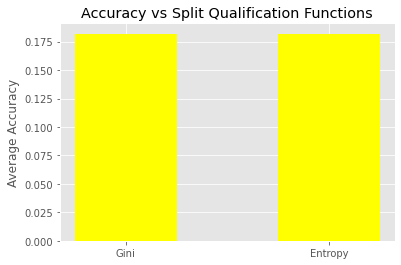

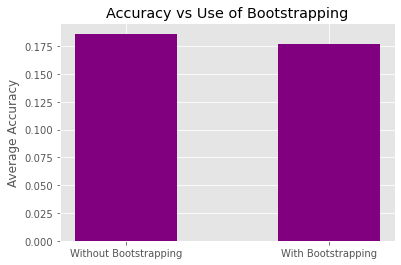

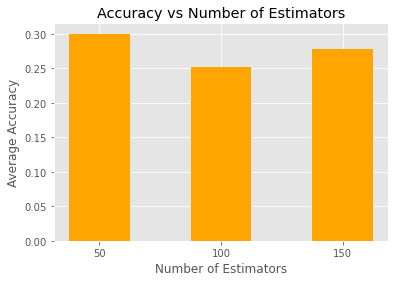

In [58]:
import matplotlib.pyplot as plt

x = ['Gini', 'Entropy']
x_bstrap = [avg_gini, avg_entropy]
x_pos = [0, .5]

plt.bar(x_pos, x_bstrap, color='yellow', width=.25)
#plt.xlabel("Boostrapping")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Split Qualification Functions")

plt.xticks(x_pos, x)

plt.show()

x = ['Without Bootstrapping', 'With Bootstrapping']
x_bstrap = [avg_false, avg_true]
x_pos = [0, .5]

plt.bar(x_pos, x_bstrap, color='purple', width=.25)
#plt.xlabel("Boostrapping")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Use of Bootstrapping")

plt.xticks(x_pos, x)

plt.show()

x = ['50', '100', '150']
x_bstrap = [avg_50, avg_100, avg_150]
x_pos = [0, .5, 1]

plt.bar(x_pos, x_bstrap, color='orange', width=.25)
plt.xlabel("Number of Estimators")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Number of Estimators")

plt.xticks(x_pos, x)

plt.show()

In [43]:
# find average accuracy with bootstrapping, without bootstrapping
bstrap_true = []
bstrap_false = []

for i, el in enumerate(inaccuracy_list):
    if bootstrapping_list[i] == True:
        bstrap_true.append(el)
    else:
        bstrap_false.append(el)
        
avg_true = sum(bstrap_true) / len(bstrap_true)
avg_false = sum(bstrap_false) / len(bstrap_false)


# find average accuracy for gini vs entropy
gini = []
entropy = []

for i, el in enumerate(inaccuracy_list):
    if criteria_list[i] == 'gini':
        gini.append(el)
    else:
        entropy.append(el)
        
avg_gini = sum(gini) / len(gini)
avg_entropy = sum(entropy) / len(entropy)


# find average accuracy for 50, 100, 150
n50 = []
n100 = []
n150 = []

for i, el in enumerate(inaccuracy_list):
    if n_estimators_list[i] == 50:
        n50.append(el)
    elif n_estimators_list[i] == 100:
        n100.append(el)
    else:
        n150.append(el)
        
avg_50 = sum(n50) / len(n50)
avg_100 = sum(n100) / len(n100)
avg_150 = sum(n150) / len(n150)

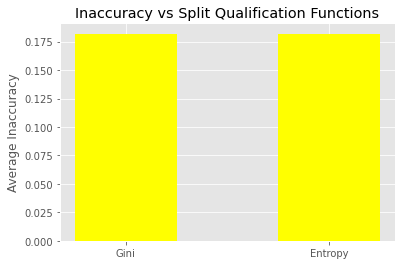

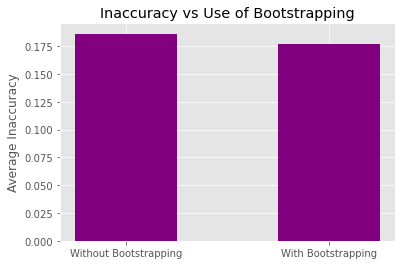

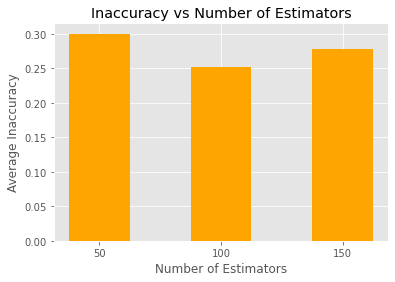

In [59]:
x = ['Gini', 'Entropy']
x_bstrap = [avg_gini, avg_entropy]
x_pos = [0, .5]

plt.bar(x_pos, x_bstrap, color='yellow', width=.25)
#plt.xlabel("Boostrapping")
plt.ylabel("Average Inaccuracy")
plt.title("Inaccuracy vs Split Qualification Functions")

plt.xticks(x_pos, x)

plt.show()

x = ['Without Bootstrapping', 'With Bootstrapping']
x_bstrap = [avg_false, avg_true]
x_pos = [0, .5]

plt.bar(x_pos, x_bstrap, color='purple', width=.25)
#plt.xlabel("Boostrapping")
plt.ylabel("Average Inaccuracy")
plt.title("Inaccuracy vs Use of Bootstrapping")

plt.xticks(x_pos, x)

plt.show()

x = ['50', '100', '150']
x_bstrap = [avg_50, avg_100, avg_150]
x_pos = [0, .5, 1]

plt.bar(x_pos, x_bstrap, color='orange', width=.25)
plt.xlabel("Number of Estimators")
plt.ylabel("Average Inaccuracy")
plt.title("Inaccuracy vs Number of Estimators")

plt.xticks(x_pos, x)

plt.show()

As you can see by the graphs, it apppears that changes in the number of estimators used, the use of bootstrapping, or differences in split function accuracy equations made a remarkable change in accuracy, although there was a small average improvement in inaccuracy with the use of bootstrapping.

**Finding Best Parameters for Adaboost**

In [47]:
# define parameters to test
estimators = [50, 100, 150]
learning_rate = np.linspace(.01, 2, 10)

n_estimators_list = []
learning_rate_list = []
accuracy_list = []
inaccuracy_list = []

for e in estimators:
    for l in learning_rate:
        ab = AdaBoostClassifier(n_estimators=e, learning_rate=l)
        ab.fit(X_train, y_train.ravel())

        ab_pred = ab.predict(X_test)

        a = check_accuracy(ab_pred, y_test, variance=.15)
        i = check_inaccuracy(ab_pred, y_test, variance=.75)

        n_estimators_list.append(e)
        learning_rate_list.append(l)
        accuracy_list.append(a)
        inaccuracy_list.append(i)

In [48]:
# highest accuracy
index_max = -1
max = 0
for j, i in enumerate(accuracy_list):
    if i>max:
        max = i
        index_max = j

# lowest inaccuracy
index_min = 0
min = inaccuracy_list[0]
for j, i in enumerate(inaccuracy_list):
    if i<min:
        min = i
        index_min = j
        
print(f'Highest Accuracy: {accuracy_list[index_max]:.3}')
print('Used ', n_estimators_list[index_max], ' estimators')
print('Used ', learning_rate_list[index_max], ' as learning rate')
print(f'Inaccuracy of afformentioned instance: {inaccuracy_list[index_max]:.3}')

print('\n')

print(f'Lowest Inaccuracy: {inaccuracy_list[index_min]:.3}')
print('Used ', n_estimators_list[index_min], ' estimators')
print(f'Used {learning_rate_list[index_min]:.3} as learning rate')
print(f'Accuracy of afformentioned instance: {accuracy_list[index_min]:.3}')

Highest Accuracy: 0.45
Used  100  estimators
Used  0.01  as learning rate
Inaccuracy of afformentioned instance: 0.399


Lowest Inaccuracy: 0.295
Used  50  estimators
Used 0.452 as learning rate
Accuracy of afformentioned instance: 0.417


In [51]:
# find average accuracy with bootstrapping, without bootstrapping
learning_rates_avg = {}

for i, el in enumerate(accuracy_list):
    if learning_rate_list[i] not in learning_rates_avg:
        learning_rates_avg[learning_rate_list[i]] = [el]
    else:
        learning_rates_avg[learning_rate_list[i]].append(el)

lrs = []
avg_lr = []

for itm in learning_rates_avg:
    lrs.append(itm)
    avg_lr.append(sum(learning_rates_avg[itm])/len(learning_rates_avg[itm]))

# find average accuracy for 50, 100, 150
n50 = []
n100 = []
n150 = []

for i, el in enumerate(accuracy_list):
    if n_estimators_list[i] == 50:
        n50.append(el)
    elif n_estimators_list[i] == 100:
        n100.append(el)
    else:
        n150.append(el)
        
avg_50 = sum(n50) / len(n50)
avg_100 = sum(n100) / len(n100)
avg_150 = sum(n150) / len(n150)

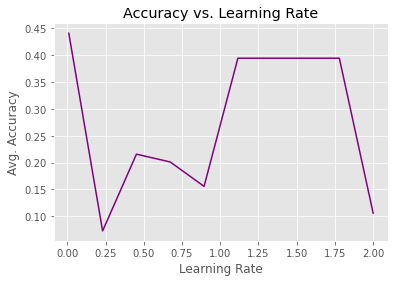

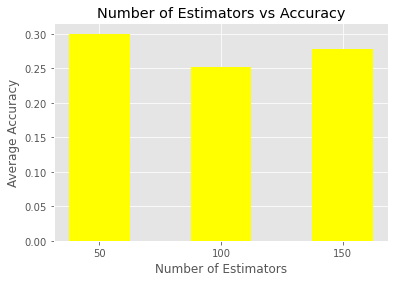

In [61]:
plt.plot(lrs, avg_lr, color='purple')
plt.title('Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Avg. Accuracy')

plt.show()


x = ['50', '100', '150']
x_bstrap = [avg_50, avg_100, avg_150]
x_pos = [0, .5, 1]

plt.bar(x_pos, x_bstrap, color='yellow', width=.25)
plt.xlabel("Number of Estimators")
plt.ylabel("Average Accuracy")
plt.title("Number of Estimators vs Accuracy")

plt.xticks(x_pos, x)

plt.show()

In [62]:
# find average accuracy with bootstrapping, without bootstrapping
learning_rates_avg = {}

for i, el in enumerate(inaccuracy_list):
    if learning_rate_list[i] not in learning_rates_avg:
        learning_rates_avg[learning_rate_list[i]] = [el]
    else:
        learning_rates_avg[learning_rate_list[i]].append(el)

lrs = []
avg_lr = []

for itm in learning_rates_avg:
    lrs.append(itm)
    avg_lr.append(sum(learning_rates_avg[itm])/len(learning_rates_avg[itm]))

# find average accuracy for 50, 100, 150
n50 = []
n100 = []
n150 = []

for i, el in enumerate(inaccuracy_list):
    if n_estimators_list[i] == 50:
        n50.append(el)
    elif n_estimators_list[i] == 100:
        n100.append(el)
    else:
        n150.append(el)
        
avg_50 = sum(n50) / len(n50)
avg_100 = sum(n100) / len(n100)
avg_150 = sum(n150) / len(n150)

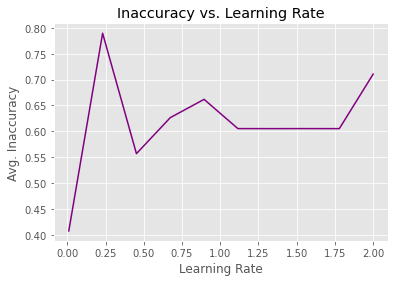

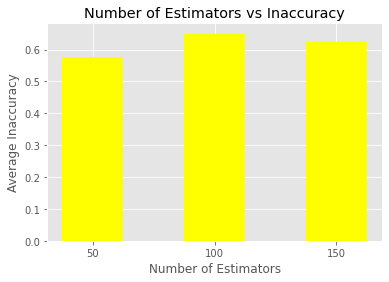

In [63]:
plt.plot(lrs, avg_lr, color='purple')
plt.title('Inaccuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Avg. Inaccuracy')

plt.show()


x = ['50', '100', '150']
x_bstrap = [avg_50, avg_100, avg_150]
x_pos = [0, .5, 1]

plt.bar(x_pos, x_bstrap, color='yellow', width=.25)
plt.xlabel("Number of Estimators")
plt.ylabel("Average Inaccuracy")
plt.title("Number of Estimators vs Inaccuracy")

plt.xticks(x_pos, x)

plt.show()

The lower the learning rate, it appears the better the accuracy and inaccuracy. It seems that the number of estimators used has a negligble effect on accuracy.

**Predicting the Month of April**

Using the results from above we are going to generate two estimations for the month of April, one seeking to minimize inaccuracy, and one seeking to maximize accuracy. We will be using Random Forest to generate this dataset since it had the 

Our highest accuracy used 100 estimators, entropy function to measure the quality of the split, and utilized bootstrapping.

Our lowest inaccuracy used 50 estimators, gini function to measure the quality of the split, but also used bootstrapping.

In [58]:
# X and y still around from cell 2

# read in april data as pandas dataframe
df = pd.read_csv('data/data_sanitized_april.csv')

# drop a couple of different metrics
del df['County']
del df['Total Sum Cases']
del df['Number of MIP Charges']

# seperating labels from features
X_april = np.asarray(df[['Days Since March 17', 
                 'Population', 
                 'Average Cases Per 7 Days', 
                 'Average Daily Change in Cases Per 7 Days', 
                 'Area of County']].copy())
y_april = np.asarray(df[['New Cases per Day']].copy())

In [61]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', bootstrap=True, n_jobs=-1)
rf.fit(X, y.ravel())
rf_pred = rf.predict(X_april)

a1 = check_accuracy(rf_pred, y_april, variance=.25)
i1 = check_inaccuracy(rf_pred, y_april, variance=.75)

rf = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, n_jobs=-1)
rf.fit(X, y.ravel())
rf_pred = rf.predict(X_april)

a2 = check_accuracy(rf_pred, y_april, variance=.25)
i2 = check_inaccuracy(rf_pred, y_april, variance=.75)

print('100 Estimators, Entropy, Bootstrapping')
print('accuracy: ', a1)
print('inaccuracy: ', i1)

print('\n')

print('50 Estimators, Gini, Bootstrapping')
print('accuracy: ', a2)
print('inaccuracy: ', i2)

100 Estimators, Entropy, Bootstrapping
accuracy:  0.5838541666666667
inaccuracy:  0.26979166666666665


50 Estimators, Gini, Bootstrapping
accuracy:  0.5739583333333333
inaccuracy:  0.26510416666666664


Overall, we were able to meet similar accuracy and innacuracy values between the training and qualification portion and then applying the best hyperparameters to April after training on March and prior. We consider this somewhat of a success. It is unfortunate not to be able to predict cases within 15% with a higher accuracy, however, the low inaccuracy rate of roughly 25% is a success. In our opinion, a high inaccuracy rate would be worse than a low accuracy rate from the standpoint that predicting a low number of cases when the actual number of cases is exceptionally high would have worse effects than predicting a low number of cases and actually getting a medium number of cases.